# Lab 1
Hara Kumar (19940905-3676)
Yeongwoo Kim (19890909-7753)

## Problem 3: Bank Robbing (Reloaded)
You are a bank robber trying to heist the bank of an unknown town.


## MDP formulation

We propose the following MDP formulation: 

#### State space $\mathcal{S}$
We model the state space as the set of all possible positions of the player and the police in the maze. 

$$\mathcal{S} = \big \lbrace  (i_r,j_r,i_p,j_p):\textrm{such that } 0<=i_r \textrm{ and } i_p<=3,\ 0<=j_r \textrm{ and } j_r<=3,\ \big\rbrace.$$
> **Note:** $\mathcal i_r \textrm{ and } j_r$ represents the position of the robber. $\mathcal i_p \textrm{ and } j_p$ represents the position of the police. The top left corner is position is $(0,0)$ and the bottom right is $(3,3)$.

#### Action space $\mathcal{A}$
The robber is allowed to choose either move `left`, `right`, `down`, `up` or `stay`. The actions are possible if the action will result in a state that could be found in the state space. 
Formally, the action space is

$$\mathcal{A} = \lbrace \textrm{up if }(i_r,(j_r + 1)) \in \mathcal{S}, \\ \textrm{ down if } (i_r,(j_r - 1)) \in \mathcal{S}, \\ \textrm{ left if } ((i_r - 1),j_r) \in \mathcal{S}, \\ \textrm{ right if } ((i_r + 1),j_r) \in \mathcal{S}, \\ \textrm{ stay} \rbrace.$$

#### Policies $\mathcal{\pi}$
- Q learning: The behavior policies of the robber and police are uniform at
random. Depending on the position of the robber or police, it exclude the impossible actions according to the action space. Within the remaining actions, the robber or police randomly select an action.\
$$ a_{r} \textrm{ and } a_{p} = uniform(\mathcal{A_{s}})$$

- SARSA: The $\epsilon$-greedy policy is applied to the robber. On the other hands, the police behave according to the uniform policy.\
$$ a_{r} =  \begin{cases} uniform(\mathcal{A_{s}}) \textrm{  w.p }  \epsilon \\
 argmax_{b \in \mathcal{A_{s}}}({Q^{(t)}}) \textrm{  w.p   } 1 - \epsilon 
            \end{cases} $$
$$ a_{p} = uniform(\mathcal{A_{s}})$$

> **Note:** $\mathcal a_r$ represents the action of the robber. $\mathcal a_p$ represents the action of the police.

#### Rewards $\mathcal{R}$
The objective of the player is to collect money from a bank while avoiding the police. This means the robber will be at the position of the bank, (1,1), and gain 1 SEK every turn. However, when the robber and police are placed on the same place, the robber will lose 10 SEK. \
$$ r =  \begin{cases} 1 SEK \textrm{ when } (i_{r},j_{r}) = (1,1) \\
- 10 SEK \textrm{ when } (i_{r},j_{r}) = (i_{p},j_{p})\\
0 SEK \textrm{ Otherwise} \end{cases} $$

### Implementation
We followed the algorithm on the slides. The biggest difference between two algorithm is that Q-learning uses behavior policy $\pi_{b}$ (Off-policy learning), but SARSA uses a $\epsilon$-greedy policy with the policy which controls the robber currently (On-policy learning). Also, Q-learning performs maximum operation on $Q^{(t)}(s_{(t+1)},a_{(t+1)})$, but the SARSA does not take the maximum operator. Therefore, SARSA coherently leverages the $\epsilon$-greedy policy.

- Q-learning : page 33 of Part 5
- SARSA :page 41 of Part 5


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [0]:
class Bank_Rob:
    def __init__(self, eps, discount, maze, init_pos, iteration):
        self.action = ['still', 'left', 'right', 'up', 'down']
        self.eps = eps
        self.maze = maze
        self.size = maze.shape
        self.iteration = iteration
        self.init_pos = init_pos.copy()
        self.current_pos = init_pos.copy()
        self.state = self.build_state()
        self.action_size = len(self.action)
        self.discount = discount
        self.Q_table = self.build_Q_table()
        self.cnt_updates = np.zeros([len(self.state), len(self.action)])
        self.stay_still = []
        self.go_right = []
        self.go_down = []
        self.SARSA_stay = []
        self.SARSA_down = []
        self.SARSA_right = []

    def check_available_actions(self, position):
        actions = self.action.copy()
        removed_idx = []
        if position[1] == 0:
            actions.remove('left')
            removed_idx.append(1)
        elif position[1] == 3:
            actions.remove('right')
            removed_idx.append(2)
        if position[0] == 0:
            actions.remove('up')
            removed_idx.append(3)
        elif position[0] == 3:
            actions.remove('down')
            removed_idx.append(4)
        return actions, removed_idx

    def pol_check_available_actions(self, position):
        actions = self.action.copy()
        removed_idx = []
        actions.remove('still')
        removed_idx.append(0)
        if position[1] == 0:
            actions.remove('left')
            removed_idx.append(1)
        elif position[1] == 3:
            actions.remove('right')
            removed_idx.append(2)
        if position[0] == 0:
            actions.remove('up')
            removed_idx.append(3)
        elif position[0] == 3:
            actions.remove('down')
            removed_idx.append(4)
        return actions, removed_idx

    def build_state(self):
        state_list = dict()
        Q_table = dict()
        cnt = 0
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                for k in range(self.size[0]):
                    for l in range(self.size[1]):
                        state_list[cnt] = [i,j,k,l]
                        cnt += 1
        return state_list 
    
    def build_Q_table(self):
        Q_table = np.zeros([len(self.state), len(self.action)])
        for key in self.state:
            actions, removed_idx = self.check_available_actions(self.state[key][0:2])
            for idx in removed_idx[::-1]:
                Q_table[key, idx] = -np.inf
        return Q_table

    def behavior_policy(self, current_postion):
        available_actions, removed_idx = self.check_available_actions(current_postion)
        selected_action = random.choice(available_actions)         
        return selected_action
    
    def e_greedy_policy(self, current_postion):
        available_actions, removed_idx = self.check_available_actions(current_postion)
        criterion = random.uniform(0, 1.0)
        if criterion < 1-self.eps:
            Q_table_idx = list(self.state.keys())[list(self.state.values()).index(self.current_pos)]
            selected_action = self.action[np.argmax(self.Q_table[Q_table_idx,:])]
        else:
            selected_action = random.choice(available_actions)    
        return selected_action
    
    
    def random_policy(self, current_postion):
        available_actions,_ = self.pol_check_available_actions(current_postion)
        selected_action = random.choice(available_actions)     
        return selected_action

    def move(self, selected_action, current_position):
        if selected_action == 'left':
            current_position[1] -= 1
        elif selected_action == 'right':
            current_position[1] += 1
        elif selected_action == 'up':
            current_position[0] -= 1
        elif selected_action  == 'down':
            current_position[0] += 1
        else:
            pass
        return current_position
        
    def check_reward(self):
        pos_robber = self.current_pos[0:2] 
        pos_police = self.current_pos[2:4]
        if pos_robber == pos_police:
            rwd = -10
        elif pos_robber == [1,1]:
            rwd = 1
        else :
            rwd = 0
        return rwd
    
    def Q_learning(self):
        #Todo: Q learning study and code it !!!!!!!!
        reward = 0
        still_idx = self.action.index('still')
        down_idx = self.action.index('down')
        right_idx = self.action.index('right')
        init_pos_idx = list(self.state.keys())[list(self.state.values()).index(self.init_pos)]
        for i in range(self.iteration):
            robber_action = self.behavior_policy(self.current_pos) #choose an action of robber
            police_action = self.random_policy(self.current_pos[2:4]) #chosse an action of police
            old_state = self.current_pos.copy() #save old state
            self.current_pos[0:2] = self.move(robber_action, self.current_pos[0:2]) #move to next state randomly
            self.current_pos[2:4] = self.move(police_action, self.current_pos[2:4]) #move to next state randomly
            reward = self.check_reward() #check the reward of the current state
            old_state_idx = list(self.state.keys())[list(self.state.values()).index(old_state)] # find the index of old state
            new_state_idx = list(self.state.keys())[list(self.state.values()).index(self.current_pos)] #find the index of new state
            robber_action_idx = self.action.index(robber_action) #find the index of robber's action
            self.cnt_updates[old_state_idx, robber_action_idx] += 1 #count up!
            alpha = 1/(self.cnt_updates[old_state_idx, robber_action_idx])**(2/3) #make the alpha according to the instruction on lab1 pdf
            self.Q_table[old_state_idx, robber_action_idx] += alpha*(reward + self.discount*np.max(self.Q_table[new_state_idx,:])- self.Q_table[old_state_idx, robber_action_idx])
            #after the forced first action, we follow the best actions! 
            self.stay_still.append(self.Q_table[init_pos_idx, still_idx])
            self.go_down.append(self.Q_table[init_pos_idx, down_idx])
            self.go_right.append(self.Q_table[init_pos_idx, right_idx])

            ten_percent = self.iteration/10

            if i%(ten_percent) ==0:
                print("Progress: "+str(i*100/self.iteration)+"%")

    def SARSA(self):
        #Todo: Q learning study and code it !!!!!!!!
        reward = 0
        still_idx = self.action.index('still')
        down_idx = self.action.index('down')
        right_idx = self.action.index('right')
        init_pos_idx = list(self.state.keys())[list(self.state.values()).index(self.init_pos)]
        for i in range(self.iteration):
            robber_action = self.e_greedy_policy(self.current_pos[0:2])
            police_action = self.random_policy(self.current_pos[2:4])
            old_state = self.current_pos.copy()
            self.current_pos[0:2] = self.move(robber_action, self.current_pos[0:2])
            self.current_pos[2:4] = self.move(police_action, self.current_pos[2:4])
            reward = self.check_reward()
            old_state_idx = list(self.state.keys())[list(self.state.values()).index(old_state)]
            new_state_idx = list(self.state.keys())[list(self.state.values()).index(self.current_pos)]
            robber_action_idx = self.action.index(robber_action)
            self.cnt_updates[old_state_idx, robber_action_idx] += 1
            alpha = 1/(self.cnt_updates[old_state_idx, robber_action_idx])**(2/3) 
            robber_future_action_idx = self.action.index(self.e_greedy_policy(self.current_pos[0:2]))
            self.Q_table[old_state_idx, robber_action_idx] += alpha*(reward + self.discount*self.Q_table[new_state_idx,robber_future_action_idx]- self.Q_table[old_state_idx, robber_action_idx]) 
            self.SARSA_stay.append(self.Q_table[init_pos_idx, still_idx])
            self.SARSA_down.append(self.Q_table[init_pos_idx, down_idx])
            self.SARSA_right.append(self.Q_table[init_pos_idx, right_idx])      

            ten_percent = self.iteration/10

            if i%(ten_percent) ==0:
                print("Progress: "+str(i*100/self.iteration)+"%")  
                
    def animate_solution(maze, path):

        # Map a color to each cell in the maze
        col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -6: LIGHT_RED, -1: LIGHT_RED};

        # Size of the maze
        rows,cols = maze.shape;

        # Create figure of the size of the maze
        fig = plt.figure(1, figsize=(cols,rows));

        # Remove the axis ticks and add title title
        ax = plt.gca();
        ax.set_title('Policy simulation');
        ax.set_xticks([]);
        ax.set_yticks([]);

        # Give a color to each cell
        colored_maze = [[col_map[maze[j,i]] for i in range(cols)] for j in range(rows)];

        # Create figure of the size of the maze
        fig = plt.figure(1, figsize=(cols,rows))

        # Create a table to color
        grid = plt.table(cellText=None,
                        cellColours=colored_maze,
                        cellLoc='center',
                        loc=(0,0),
                        edges='closed');

        # Modify the hight and width of the cells in the table
        tc = grid.properties()['child_artists']
        for cell in tc:
            cell.set_height(1.0/rows);
            cell.set_width(1.0/cols);


        # Update the color at each frame
        for i in range(len(path)):
            if i > 0:
                if path[i][0] == path[i-1][0] and path[i][1] != path[i-1][1]:
                    grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
                    grid.get_celld()[(path[i-1][1])].get_text().set_text('')
                elif path[i][0] != path[i-1][0] and path[i][0] == path[i-1][0]:
                    grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
                    grid.get_celld()[(path[i-1][0])].get_text().set_text('')
                elif path[i][0] != path[i-1][0] and path[i][0] != path[i-1][0]:
                    grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
                    grid.get_celld()[(path[i-1][0])].get_text().set_text('')
                    grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
                    grid.get_celld()[(path[i-1][1])].get_text().set_text('')
                    
            grid.get_celld()[(path[i][0])].set_facecolor(LIGHT_ORANGE)
            grid.get_celld()[(path[i][0])].get_text().set_text('Robber')
            grid.get_celld()[(path[i][1])].set_facecolor(LIGHT_PURPLE)
            grid.get_celld()[(path[i][1])].get_text().set_text('Police')

            display.display(fig)
            display.clear_output(wait=True)
            time.sleep(1)

In [0]:
initial_pos = [0,0,3,3]
maze =  np.array([[0,0,0,0],
                 [0,1,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])


## Result
The both algorithms show convergences.

- Q-learning: This algorithm takes the maximum of $Q^{(t)}(s_{(t+1)},a_{(t+1)})$. This means the robber will take the best choice after the current random action. Therefore, the algorithm converges to the optimum fast. In case of the `stay`, it shows lower Q value than the other actions, since the route to the bank should include `right` or `down`. Accordingly, the `right` and `down` show the similar values.

- SARSA: This algorithm continues to exploration by the chance of $\epsilon$. Therefore, this algorithm converges slower than the Q-learning. As the $\epsilon$, it also shows the convergence takes more time and might converge to the different value than the optimum value.
 


In [169]:
rob_bank = Bank_Rob(0.1, 0.8, maze, initial_pos, 10000000)
rob_bank.Q_learning()

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


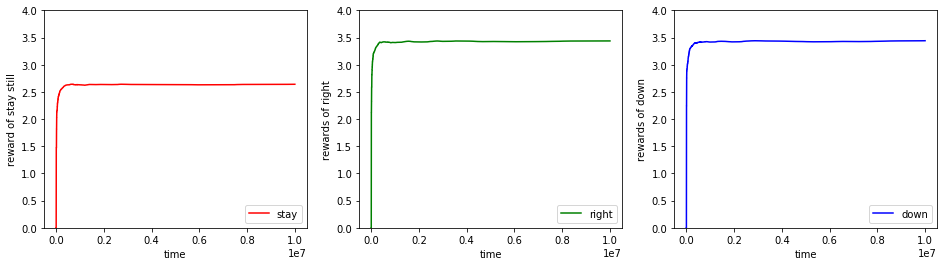

In [170]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(rob_bank.stay_still,'r', label='stay')
plt.ylim(0, 4)
plt.legend(loc="lower right")
plt.ylabel('reward of stay still')
plt.xlabel('time')

plt.subplot(1,3,2)
plt.plot(rob_bank.go_right,'g', label='right')
plt.ylim(0, 4)
plt.legend(loc="lower right")
plt.ylabel('rewards of right')
plt.xlabel('time')

plt.subplot(1,3,3)
plt.plot(rob_bank.go_down,'b', label='down')
plt.ylim(0, 4)
plt.legend(loc="lower right")
plt.ylabel('rewards of down')
plt.xlabel('time')

plt.show()

In [171]:
lst = [0.1, 0.2, 0.3, 0.4]
SARSA_diff_eps=dict()
for e in lst:
    rob_bank = Bank_Rob(e, 0.8, maze, initial_pos, 10000000)
    rob_bank.SARSA()
    SARSA_diff_eps[e] = {'stay': rob_bank.SARSA_stay, 'right': rob_bank.SARSA_right, 'down': rob_bank.SARSA_down}

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


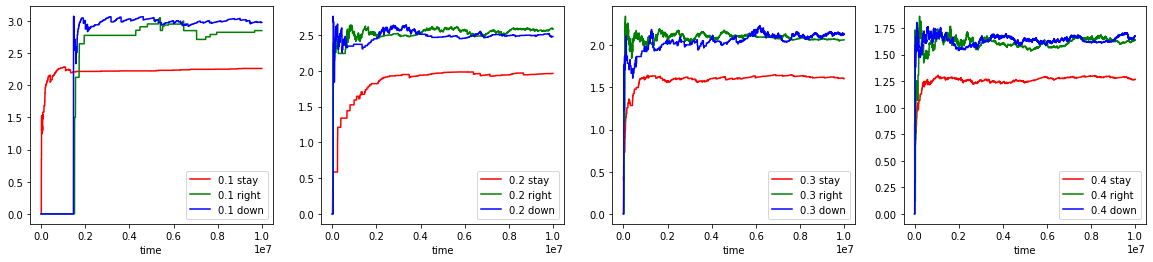

In [172]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(SARSA_diff_eps[0.1]['stay'],'r', label='0.1 stay')
plt.plot(SARSA_diff_eps[0.1]['right'],'g', label='0.1 right')
plt.plot(SARSA_diff_eps[0.1]['down'],'b', label='0.1 down')
plt.legend(loc="lower right")
plt.xlabel('time')

plt.subplot(1,4,2)
plt.plot(SARSA_diff_eps[0.2]['stay'],'r', label='0.2 stay')
plt.plot(SARSA_diff_eps[0.2]['right'],'g', label='0.2 right')
plt.plot(SARSA_diff_eps[0.2]['down'],'b', label='0.2 down')
plt.legend(loc="lower right")
plt.xlabel('time')

plt.subplot(1,4,3)
plt.plot(SARSA_diff_eps[0.3]['stay'],'r', label='0.3 stay')
plt.plot(SARSA_diff_eps[0.3]['right'],'g', label='0.3 right')
plt.plot(SARSA_diff_eps[0.3]['down'],'b', label='0.3 down')
plt.legend(loc="lower right")
plt.xlabel('time')

plt.subplot(1,4,4)
plt.plot(SARSA_diff_eps[0.4]['stay'],'r', label='0.4 stay')
plt.plot(SARSA_diff_eps[0.4]['right'],'g', label='0.4 right')
plt.plot(SARSA_diff_eps[0.4]['down'],'b', label='0.4 down')
plt.legend(loc="lower right")
plt.xlabel('time')
plt.show()